# Measuring cortical depth

The idea here is:
1. Take the contour of the structure of interest,
2. Find the depth of all the points of the contour,
3. Apply the registration on the contour so that it ends up on the slice,
4. Either (a) look again for the closest points and get those distances or (b) use the same points as in 2 to get an idea of how the depths have changed.

## 0. Preparations

### Usual suspects

In [1]:
import numpy as np

from helper_loader import *

### Load the alignment

In [2]:
alignment_path = Path(
    "/home/ediun/git/histalign/projects/project_cortical_depth/9f5d5f117d/7b067a31b027506e3b39b5679a5151f9.json"
)
alignment_settings = load_alignment_settings(alignment_path)

### Load the image

In [3]:
image = load_image(alignment_settings.histology_path)

## 1. Load the contours

In [4]:
isocortex_volume = load_structure_mask(
    "Isocortex",
    alignment_settings.volume_settings.resolution,
    return_raw_array=False,
)
cortical_structure_volume = load_structure_mask(
    "Primary motor area, Layer 1",
    alignment_settings.volume_settings.resolution,
    return_raw_array=False,
)

In [5]:
isocortex_slice = VolumeSlicer(volume=isocortex_volume).slice(
    alignment_settings.volume_settings
)
cortical_structure_slice = VolumeSlicer(volume=cortical_structure_volume).slice(
    alignment_settings.volume_settings
)

In [6]:
isocortex_contour = compute_largest_contour(isocortex_slice)
cortical_structure_contour = compute_largest_contour(cortical_structure_slice)

## 2. Find the depths of the cortical structure

In [7]:
isocortex_points = np.flipud(np.squeeze(isocortex_contour))
cortical_structure_points = np.flipud(np.squeeze(cortical_structure_contour))

In [8]:
closest_isocortex_points = compute_closest_contour_point(
    cortical_structure_points, isocortex_points
)

In [9]:
normal_depths = compute_distances_nonisometric_grid(
    cortical_structure_points,
    closest_isocortex_points,
    alignment_settings.volume_settings.resolution,
    alignment_settings.volume_settings.resolution,
)

## 3. Apply reverse registration on contour(s)

In [10]:
np.concatenate([np.array([1, 2]), [3]])

array([1, 2, 3])

In [11]:
def apply_transformation_matrix_to_contour(
    transformation_matrix: np.ndarray,
    contour: np.ndarray,
) -> np.ndarray:
    return np.array(
        [
            np.matmul(transformation_matrix, np.concatenate([point, [1]]))[:2]
            for point in contour
        ]
    )

In [12]:
transformation_matrix = get_transformation_matrix_from_q_transform(
    recreate_q_transform_from_alignment(
        isocortex_slice.shape,
        alignment_settings,
        True,
    ),
    True,
)

registered_cortical_structure_points = apply_transformation_matrix_to_contour(
    transformation_matrix,
    cortical_structure_points,
)
registered_closest_isocortex_points = apply_transformation_matrix_to_contour(
    transformation_matrix,
    closest_isocortex_points,
)

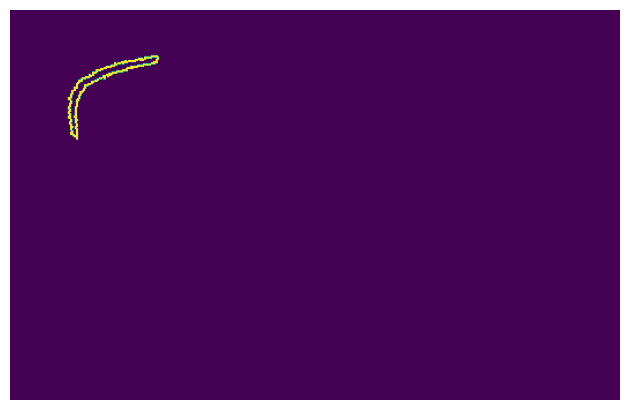

In [14]:
tmp_image1 = np.zeros_like(isocortex_slice).astype(np.uint16)
for point in registered_cortical_structure_points:
    i = round(point[1])
    j = round(point[0])
    i_slice = slice(i - 1, i + 1)
    j_slice = slice(j - 1, j + 1)
    tmp_image1[
        i_slice,
        j_slice,
    ] = (
        2**16 - 1
    )

imshow(
    tmp_image1,
    vmin=0,
    vmax=2**16 - 1,
)

In [15]:
isocortex_points[0]

array([301,  36], dtype=int32)

In [16]:
closest_isocortex_points[0]

array([168,  84], dtype=int32)

In [18]:
registered_cortical_structure_points[10]

array([120.253123,  47.533809])

In [19]:
registered_closest_isocortex_points[10]

array([116.743687,  43.029184])

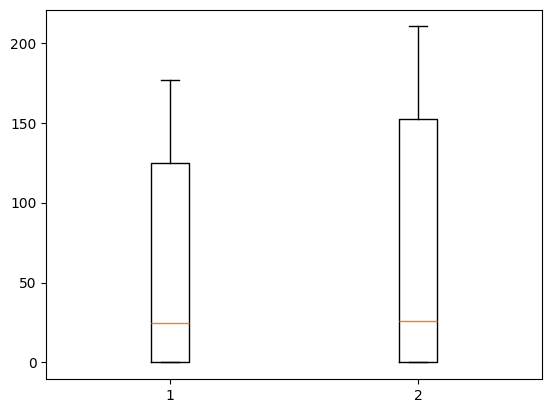

In [35]:
registered_depths = compute_distances_nonisometric_grid(
    registered_cortical_structure_points,
    registered_closest_isocortex_points,
    alignment_settings.volume_settings.resolution
    / alignment_settings.histology_settings.scale_x,
    alignment_settings.volume_settings.resolution
    / alignment_settings.histology_settings.scale_y,
)
plt.boxplot([normal_depths, registered_depths]);

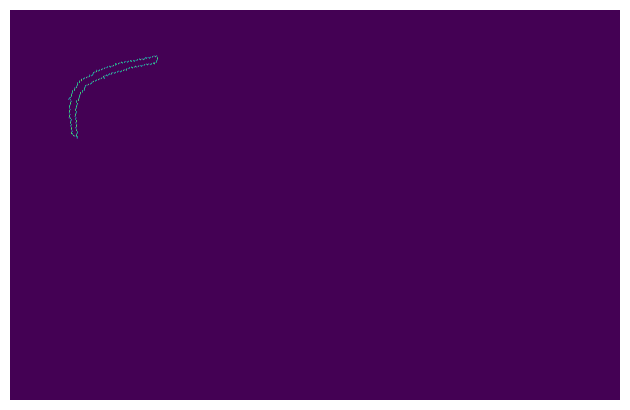

In [24]:
tmp_image1 = np.zeros(
    shape=np.round(
        np.array(isocortex_slice.shape)
        * Registrator._get_volume_scaling_factor(alignment_settings)
    )
    .astype(np.uint16)
    .tolist()
).astype(np.uint16)
# tmp_image1 = image.copy()
for point in registered_cortical_structure_points:
    i = round(point[1] * Registrator._get_volume_scaling_factor(alignment_settings))
    j = round(point[0] * Registrator._get_volume_scaling_factor(alignment_settings))
    i_slice = slice(i - 10, i + 10)
    j_slice = slice(j - 10, j + 10)
    tmp_image1[
        i_slice,
        j_slice,
    ] = (
        2**16 - 1
    )

imshow(
    tmp_image1,
    vmin=0,
    vmax=2**16 - 1,
)

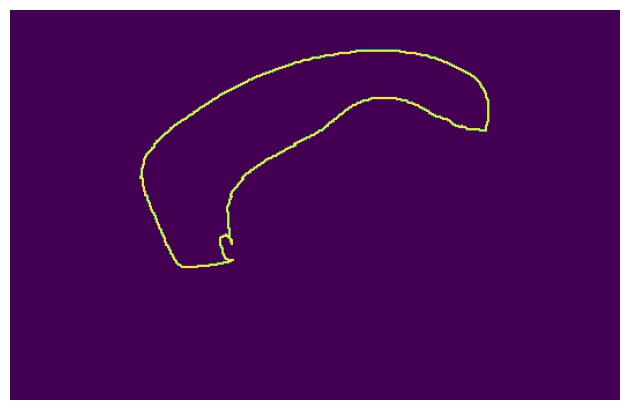

In [25]:
tmp_image1 = np.zeros_like(isocortex_slice).astype(np.uint16)
for point in isocortex_points:
    i = round(point[1])
    j = round(point[0])
    i_slice = slice(i - 1, i + 1)
    j_slice = slice(j - 1, j + 1)
    tmp_image1[
        i_slice,
        j_slice,
    ] = (
        2**16 - 1
    )

imshow(tmp_image1, vmin=0, vmax=2**16 - 1)